In [9489]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [9490]:
inputdata1 = "../output_mo/combined_mo_data/" 
inputdata2 = "../output_qt/combined_qt_data/" #just to get gdp_total
outputdata1 = "../output_mo/regressiondata_mo/"

In [9491]:
def x_data():
    x_data = pd.read_csv(inputdata1 + "a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [9492]:
def y_data(seasonal=True):
    if seasonal:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total_deseasonalized'].to_frame()
    else:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)['gdp_total'].to_frame()

    upsampled = y_data.resample('MS')
    y_data = upsampled.interpolate(method='spline', order=2)

    return y_data


### Combine Y and X data

In [9493]:
regressionData = y_data(seasonal=True).merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")

start_date_analysis = "1998-08-01"  # make divisible by 12 to make coding easier
save_some_data_for_predictions = "2024-07-01"
df1 = regressionData.loc[start_date_analysis:save_some_data_for_predictions,:].copy()


### Save transformations of GDP

In [9494]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))


GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()


In [9495]:
# subset of the data
df1 = df1[['gdp_total', 
          '^AEX', 
          '^FVX',
          '^TNX',
          '^TYX',

          'Bankruptcies',
          'Consumentenvertrouwen_1',
          'EconomischKlimaat_2',
          'Koopbereidheid_3',
          'EconomischeSituatieLaatste12Maanden_4',
          'EconomischeSituatieKomende12Maanden_5',
          'FinancieleSituatieLaatste12Maanden_6',
          'FinancieleSituatieKomende12Maanden_7',
          'GunstigeTijdVoorGroteAankopen_8',
          'CPI_1',
          'MaandmutatieCPI_3',
          'ProducerConfidence_1', 
          'ExpectedActivity_2',

          'Crude oil, Brent',
          'Coal, Australian',
          'Natural gas, Europe', 
          'Natural gas index',

          'Gold', 
          'Platinum',
          'M3_1', 
          'M3_2',
          'M1',

          'CCICP_NLD_CLI', 
          'BCICP_NLD_CLI',
          'BCICP_DEU',

          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
           
          #'United States_unemply_F',
          'United States_unemply_M', 
        ]]


### Drop if number of observations less than GDP

In [9496]:

def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)
df1

[]


,gdp_total,^AEX,^FVX,^TNX,^TYX,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,EconomischeSituatieLaatste12Maanden_4,...,Platinum,M3_1,M3_2,M1,CCICP_NLD_CLI,BCICP_NLD_CLI,BCICP_DEU,Netherlands_unemply_F,Netherlands_unemply_M,United States_unemply_M
1998-08-01,152046.814069,524.570796,5.261000,5.328190,5.534381,326.0,30.0,37.0,26.0,46.0,...,369.18,295743.0,278768.0,98435.0,101.74370,101.0205,100.13330,6.4,3.3,4.0
1998-09-01,152356.674537,458.109500,4.611143,4.783381,5.198476,540.0,24.0,22.0,25.0,36.0,...,361.15,298989.0,282330.0,100487.0,101.36320,100.9079,99.88960,6.7,3.4,4.2
1998-10-01,152911.000000,419.906605,4.170762,4.507000,5.005000,364.0,14.0,0.0,22.0,21.0,...,342.60,299452.0,282758.0,102528.0,101.10340,100.6339,99.63366,6.7,3.4,4.0
1998-11-01,153794.727794,487.022041,4.525474,4.819526,5.244737,378.0,11.0,-5.0,21.0,15.0,...,347.18,299267.0,282626.0,103516.0,101.07370,100.3912,99.44672,6.6,3.4,3.9
1998-12-01,154881.044944,503.840076,4.436273,4.633318,5.053000,306.0,13.0,-2.0,23.0,16.0,...,351.79,299699.0,282829.0,104192.0,101.06950,100.2846,99.28580,6.1,3.0,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,234863.025267,863.843002,4.201850,4.208100,4.362250,345.0,-22.0,-35.0,-14.0,-42.0,...,908.75,1156784.0,1071931.0,429466.0,99.40374,100.0773,98.83169,3.8,3.6,4.1
2024-04-01,235834.000000,877.564285,4.558182,4.538318,4.656955,427.0,-21.0,-34.0,-13.0,-40.0,...,940.18,1141262.0,1056337.0,423306.0,99.38277,100.1739,98.79931,3.7,3.5,3.7
2024-05-01,236624.203208,906.555914,4.499955,4.481955,4.618364,343.0,-22.0,-38.0,-12.0,-43.0,...,1014.68,1158783.0,1073759.0,432305.0,99.35704,100.2616,98.79533,3.6,3.5,4.0
2024-06-01,237287.255097,922.693997,4.318842,4.305105,4.445632,377.0,-23.0,-38.0,-14.0,-46.0,...,985.08,1152080.0,1066696.0,426029.0,99.36520,100.3004,98.76119,3.8,3.5,4.1


### Add 'sure' data and random data

In [9497]:
# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

### Standard Scaler

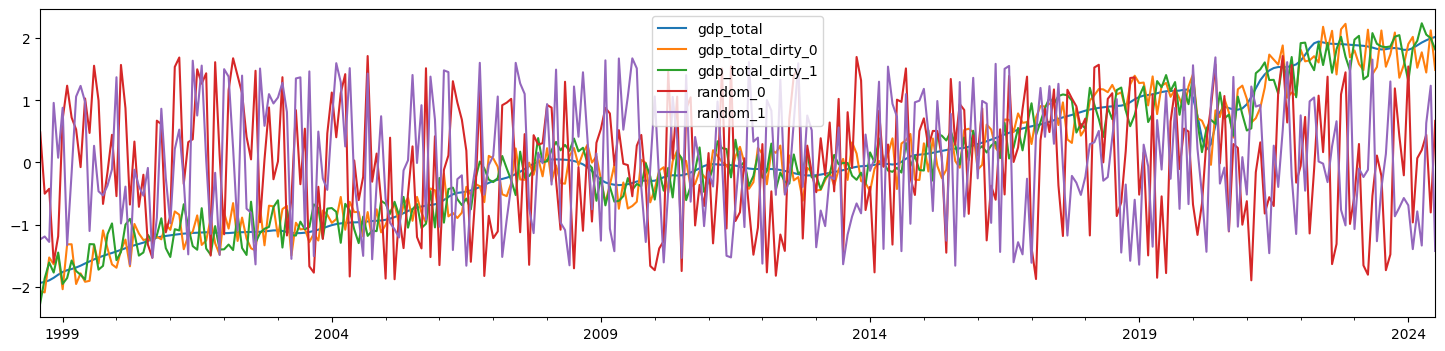

In [9498]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]

In [9499]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [9500]:
def seasonality_test(data):
    kw_test1 = data.loc[start_date_analysis:save_some_data_for_predictions,:]
    kw_test1['Months'] = [1,2,3,4,5,6,7,8,9,10,11,12] * int(len(kw_test1)/12)
    kw_test1['Semi'] = [1,2,3,4,5,6] * int(len(kw_test1)/6)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

In [9501]:
def Kruskal_Wallis_Monthly(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Months'].unique():
            res.append(data[data['Months'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Monthly_Seasonality'] = 'No_Monthly_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Monthly_Seasonality'] = 'Monthly_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Monthly(kw1, STORE_FOR_TESTS)

In [9502]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [9503]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
# Causing loss of data!!!
#scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    print(i)
    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.to_csv("tmp_scaled_features_df.csv ")

MaandmutatieCPI_3
United States_unemply_M
random_1


[ 0  1  3  6  8 10 12 13 16 18 19 20 21 22 23 25 26 27 28 29 30 31 32 33
 35]
['^AEX', '^FVX', '^TYX', 'EconomischKlimaat_2', 'EconomischeSituatieLaatste12Maanden_4', 'FinancieleSituatieLaatste12Maanden_6', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'ExpectedActivity_2', 'Coal, Australian', 'Natural gas, Europe', 'Natural gas index', 'Gold', 'Platinum', 'M3_1', 'M1', 'CCICP_NLD_CLI', 'BCICP_NLD_CLI', 'BCICP_DEU', 'Netherlands_unemply_F', 'Netherlands_unemply_M', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1']


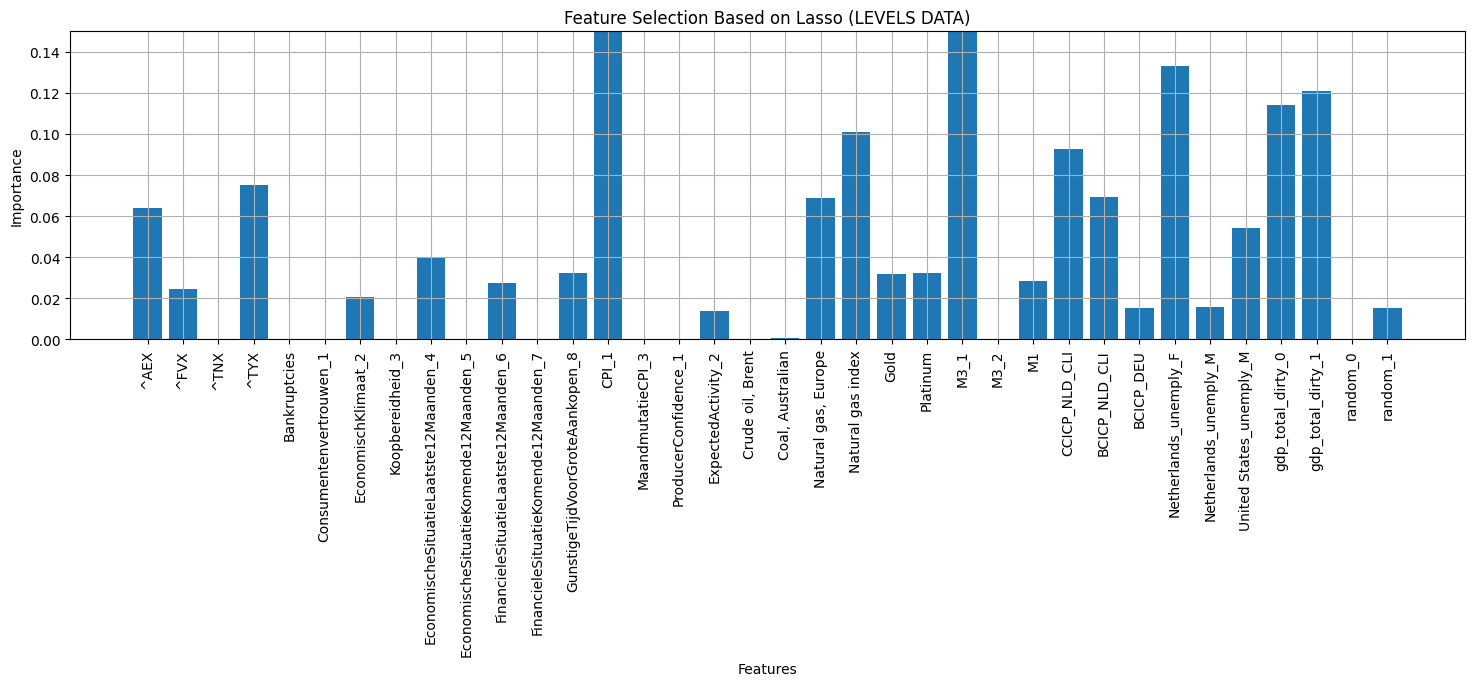

(312, 37)


In [9504]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.001, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  3  4  8  9 10 11 12 13 14 15 16 17 18 20 21 22 25 26 27 28 30 31 32
 33 34]
['^AEX', '^TYX', 'Bankruptcies', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'MaandmutatieCPI_3', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Crude oil, Brent', 'Coal, Australian', 'Natural gas index', 'Gold', 'Platinum', 'M1', 'CCICP_NLD_CLI', 'BCICP_NLD_CLI', 'BCICP_DEU', 'Netherlands_unemply_M', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0']


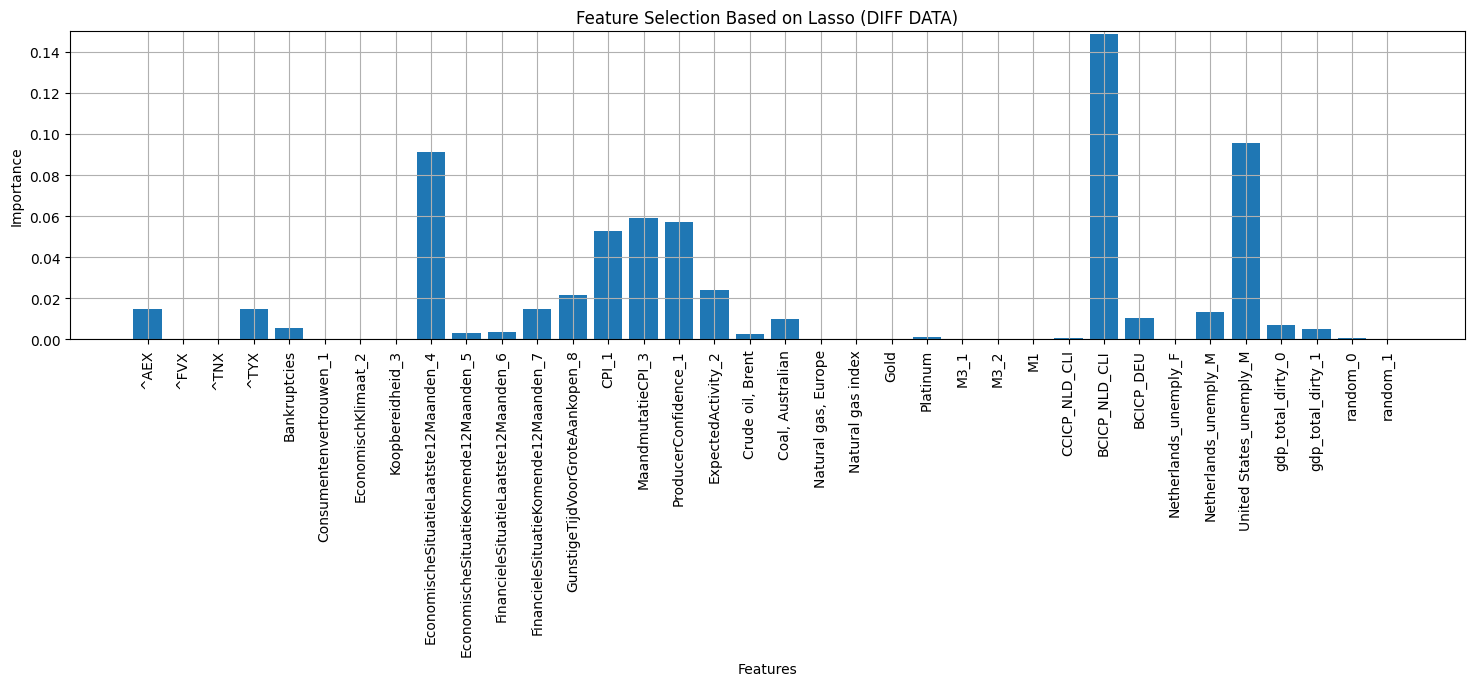

In [9505]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (DIFF DATA)'); 

In [9506]:
def lag_data(data):
    # only returns lags of variables, not original data
    df1 = data.copy()
    number_lags = 1

    for lag in range(1, number_lags+1):
        for col in df1.columns:
            df1[col + '_lag_' + str(lag)] = df1[col].shift(lag)
        
    selectThese = [col for col in df1.columns if '_lag_' in col]
    df_lag = df1[selectThese]

    return df_lag

df_lag  = lag_data(scaled_features_df)
df_lag.insert(loc=0, column='gdp_total', value=scaled_features_df['gdp_total'])

[ 0  2  4  5  8  9 10 11 12 13 14 15 16 17 19 20 21 23 25 26 27 28 29 30
 31 32 33 35 36]
['gdp_total_lag_1', '^FVX_lag_1', '^TYX_lag_1', 'Bankruptcies_lag_1', 'Koopbereidheid_3_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'CPI_1_lag_1', 'MaandmutatieCPI_3_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Coal, Australian_lag_1', 'Natural gas, Europe_lag_1', 'Natural gas index_lag_1', 'Platinum_lag_1', 'M3_2_lag_1', 'M1_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_M_lag_1', 'gdp_total_dirty_0_lag_1', 'random_0_lag_1', 'random_1_lag_1']


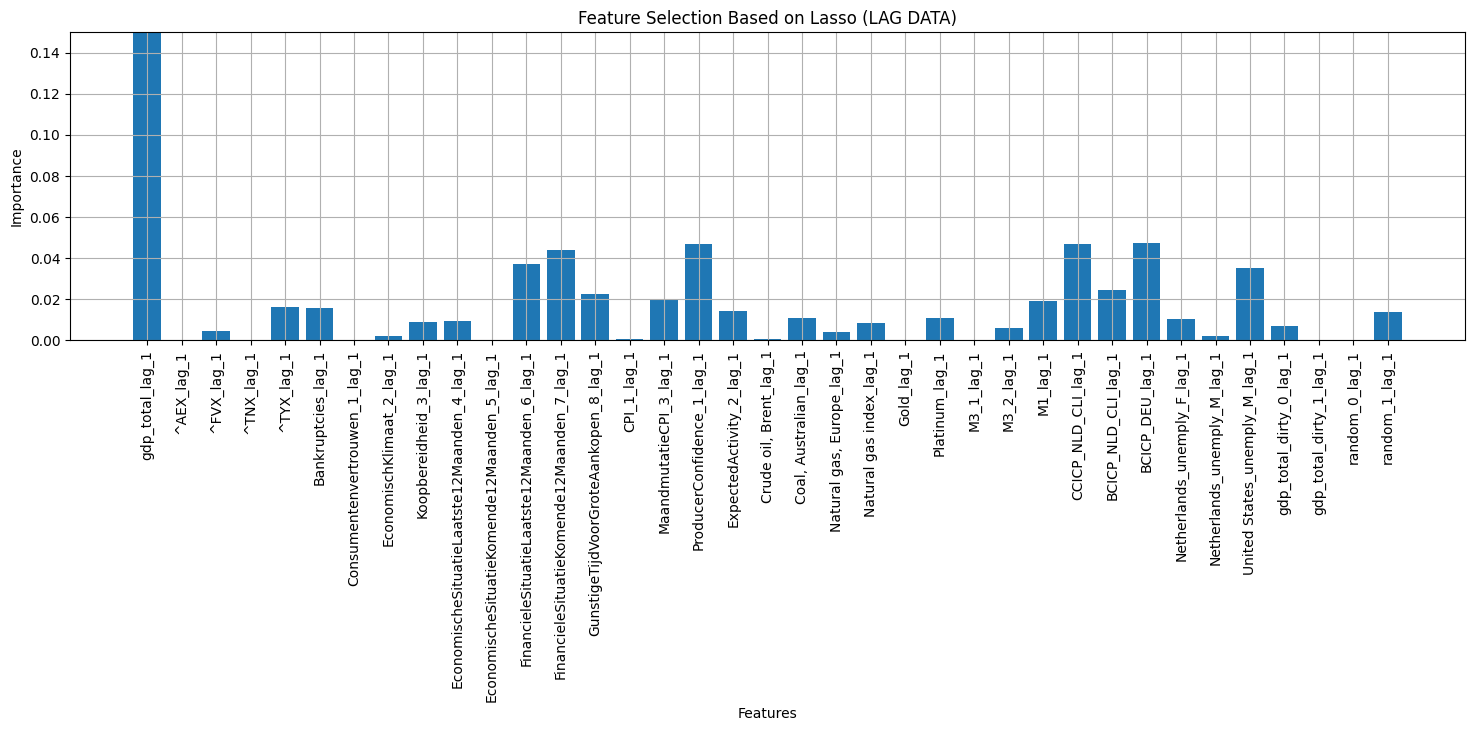

In [9507]:
lassoreg(df_lag, alpha=0.0001, title='Feature Selection Based on Lasso (LAG DATA)'); 

[ 0  4  5  9 10 11 12 13 16 17 18 19 26 27 28 29 31 32 33 35 36]
['gdp_total_lag_1', '^TYX_lag_1', 'Bankruptcies_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Coal, Australian_lag_1', 'M1_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_M_lag_1', 'gdp_total_dirty_0_lag_1', 'random_0_lag_1', 'random_1_lag_1']


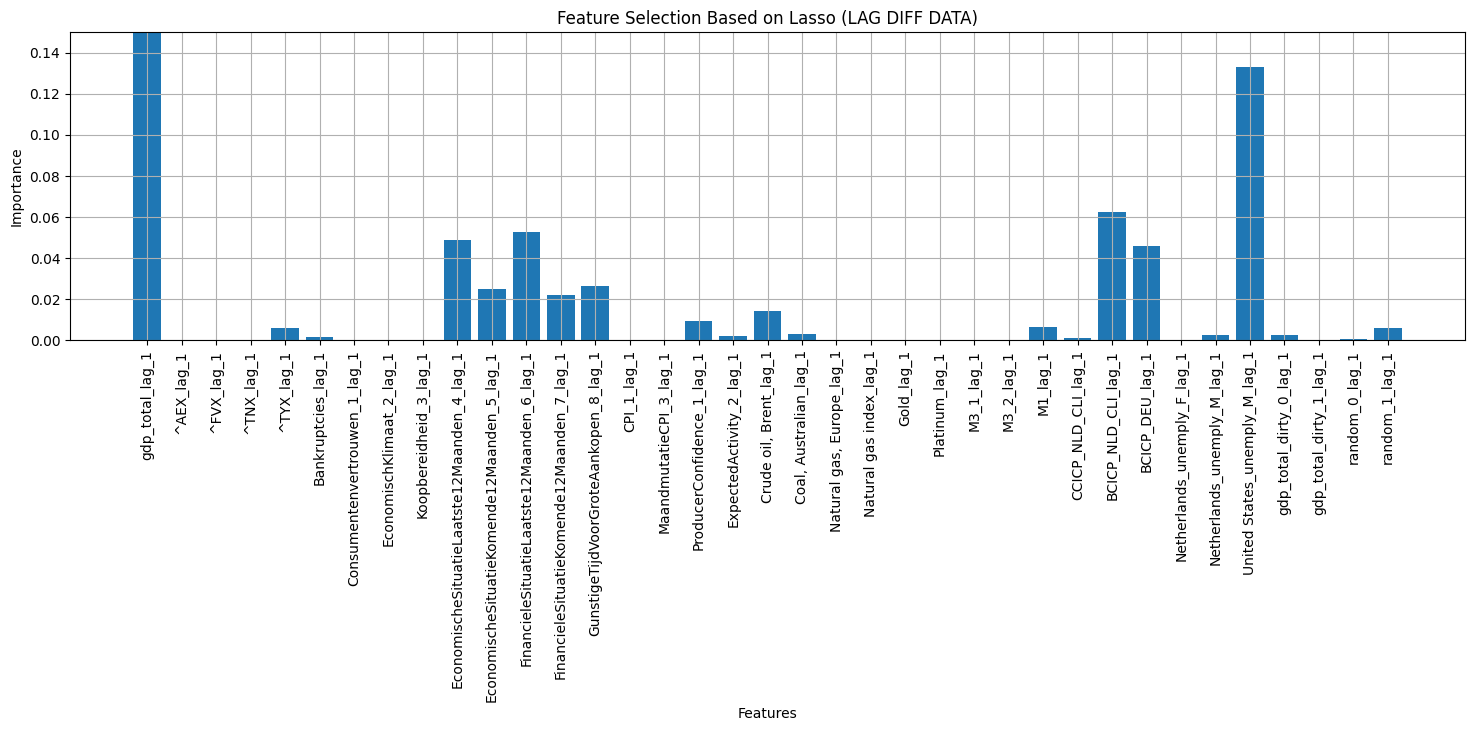

In [9508]:
lassoreg(df_lag.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (LAG DIFF DATA)'); 


### Make sure data is stationary

In [9509]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)

(37, 3)


### If not stationary, difference, then test for stationarity again

In [9510]:
def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]


In [9511]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^FVX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TNX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TYX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
EconomischeSituatieLaatste12Maanden_4,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality


<Axes: >

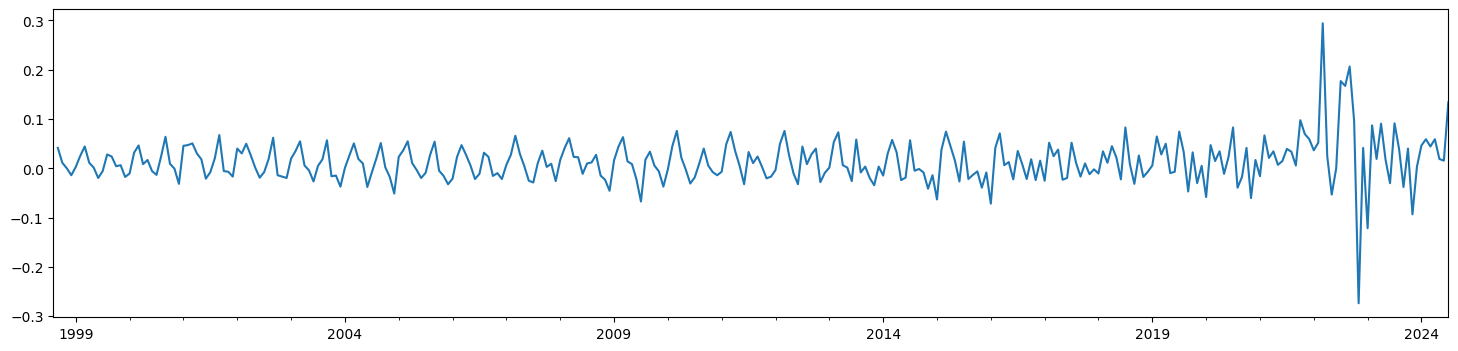

In [9512]:
scaled_features_df_diff['CPI_1'].plot()

[ 0  8 12 15 16 17 26 28 32 33 34]
['^AEX', 'EconomischeSituatieLaatste12Maanden_4', 'GunstigeTijdVoorGroteAankopen_8', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Crude oil, Brent', 'CCICP_NLD_CLI', 'BCICP_DEU', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0']


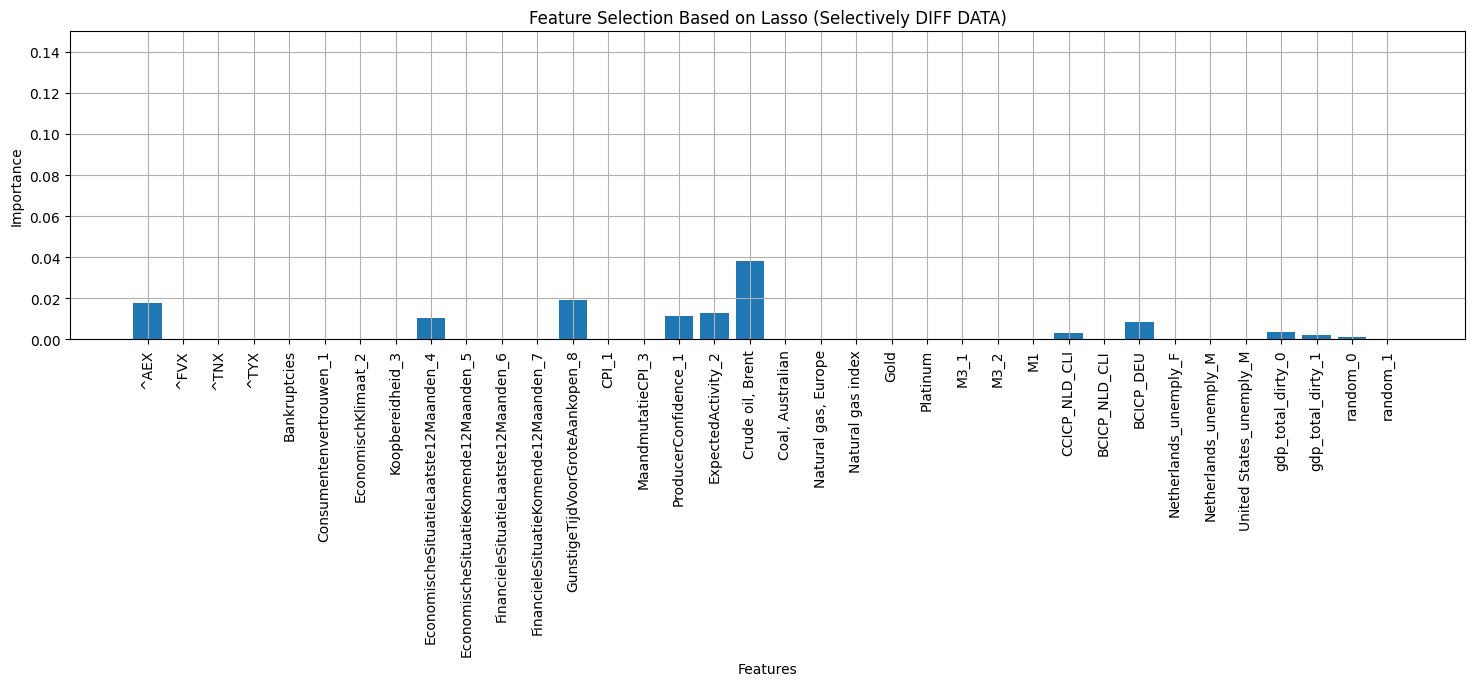

['^AEX',
 'EconomischeSituatieLaatste12Maanden_4',
 'GunstigeTijdVoorGroteAankopen_8',
 'ProducerConfidence_1',
 'ExpectedActivity_2',
 'Crude oil, Brent',
 'CCICP_NLD_CLI',
 'BCICP_DEU',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0']

In [9513]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

<Axes: >

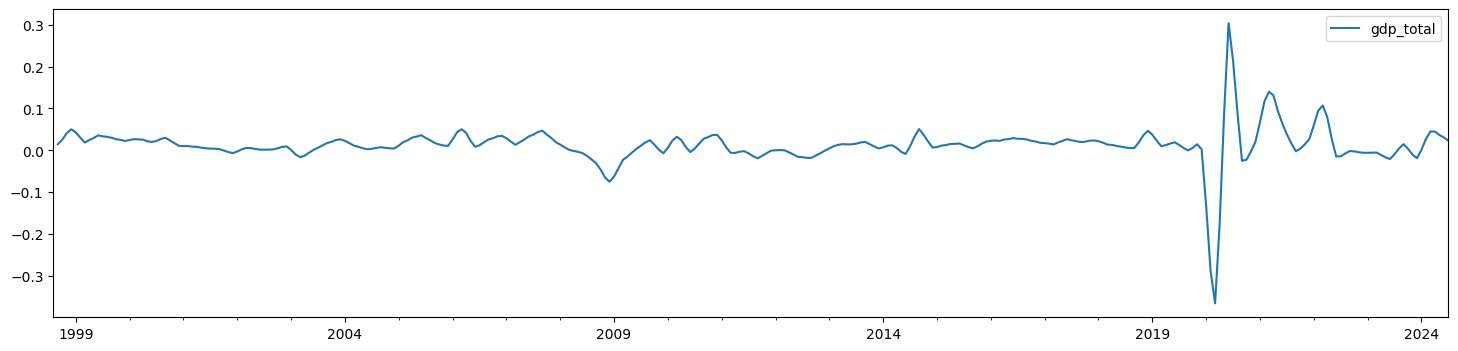

In [9514]:
scaled_features_df_diff[['gdp_total']].plot()

In [9515]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(312, 74)


In [9516]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

In [9517]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(312, 34)


[ 0 16 17 18 21 27 29]
['gdp_total_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Natural gas index_lag_1', 'CCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1']


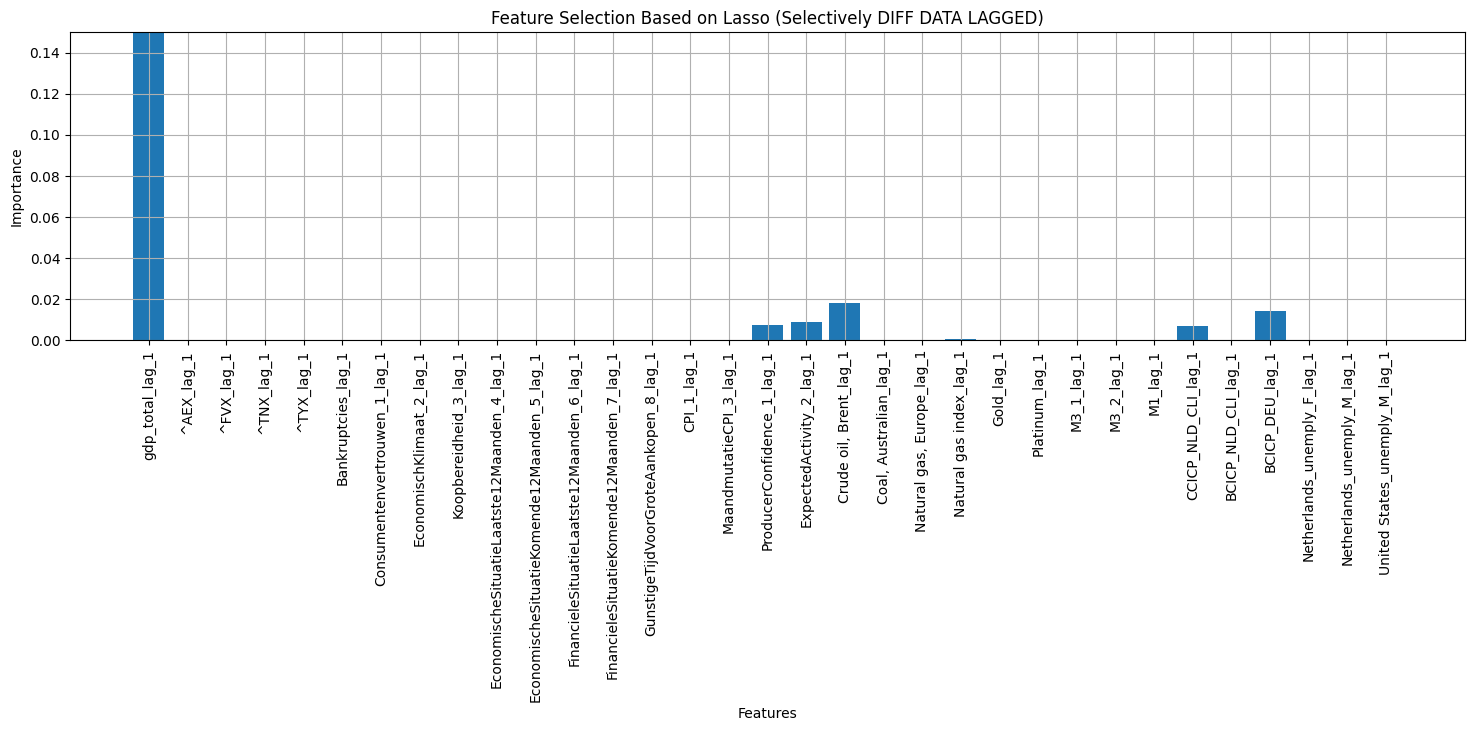

In [9518]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

,gdp_total,gdp_total_lag_1,ProducerConfidence_1_lag_1,ExpectedActivity_2_lag_1,"Crude oil, Brent_lag_1",Natural gas index_lag_1,CCICP_NLD_CLI_lag_1,BCICP_DEU_lag_1
1998-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-09-01,0.014306,NaN,0.503699,0.472345,NaN,-1.193485,1.343165,-0.176516
1998-10-01,0.025592,0.014306,0.487742,0.586155,0.048715,-1.161526,1.042656,-0.350280
1998-11-01,0.040800,0.025592,0.040965,-0.109352,-0.026341,-1.202509,0.837473,-0.532772
1998-12-01,0.050153,0.040800,-0.054773,-0.223162,-0.054000,-1.155935,0.814017,-0.666065
...,...,...,...,...,...,...,...,...
2024-03-01,0.044845,0.026856,-0.421769,-0.235808,0.116462,-0.575121,-0.562282,-1.081302
2024-04-01,0.044828,0.044845,-0.517507,-0.374909,0.055416,-0.595021,-0.504873,-1.104597
2024-05-01,0.036482,0.044828,-0.326031,-0.147289,0.151694,-0.542672,-0.521435,-1.127685
2024-06-01,0.030612,0.036482,-0.198380,0.092977,-0.265357,-0.326619,-0.541756,-1.130522


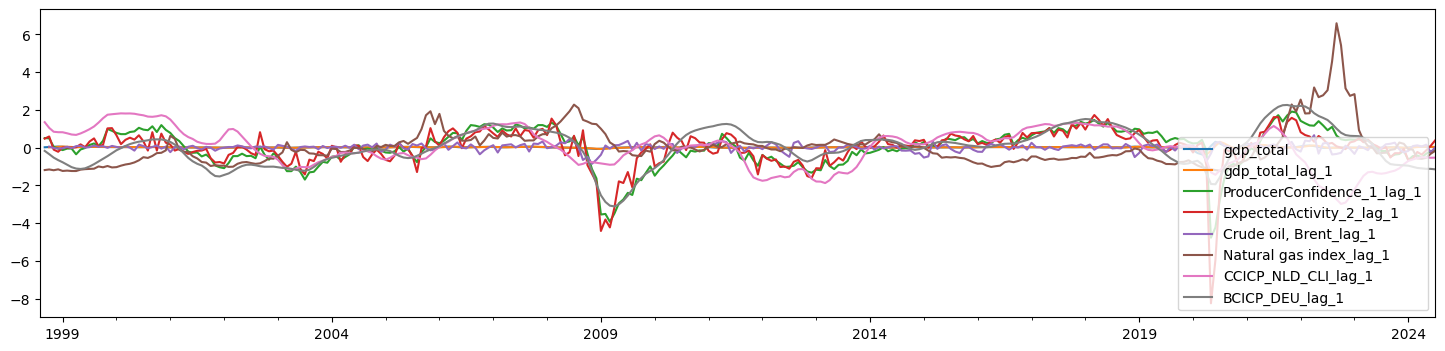

In [9519]:
chooseThese = ['gdp_total'] + lasout
scaled_features_df_diff_lag[chooseThese].plot()
scaled_features_df_diff_lag[chooseThese]

<Axes: >

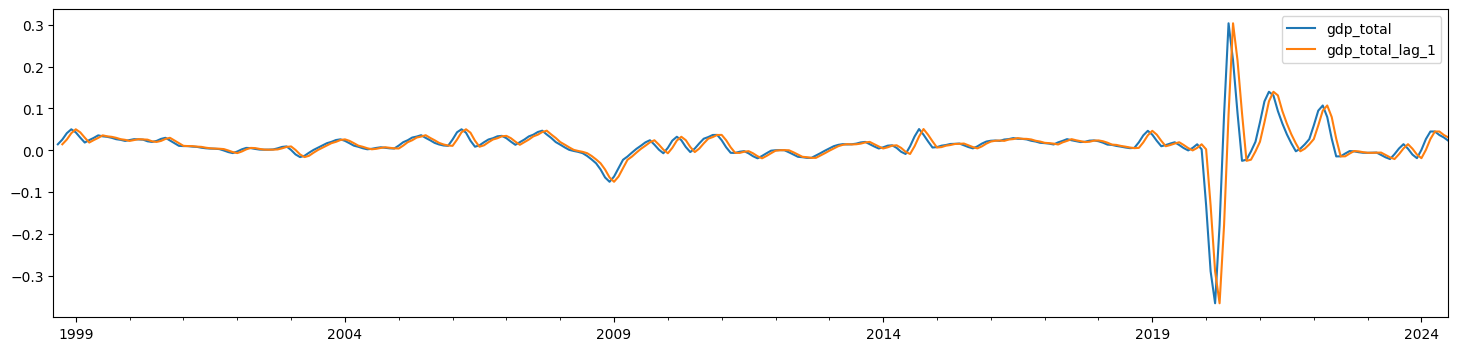

In [9520]:
scaled_features_df_diff_lag[['gdp_total','gdp_total_lag_1']].plot()

In [9521]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")

reg1.dropna(inplace=True)

##################################
test_start_date = start_date_analysis
end_test_date = '2023-03-01'
##################################

X = reg1.loc[test_start_date:end_test_date, chooseThese[1]:]
X = sm.add_constant(X)

y_true = reg1.loc[test_start_date:end_test_date:, 'gdp_total']

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     101.7
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           7.75e-74
Time:                        14:53:12   Log-Likelihood:                 678.69
No. Observations:                 294   AIC:                            -1341.
Df Residuals:                     286   BIC:                            -1312.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<Axes: >

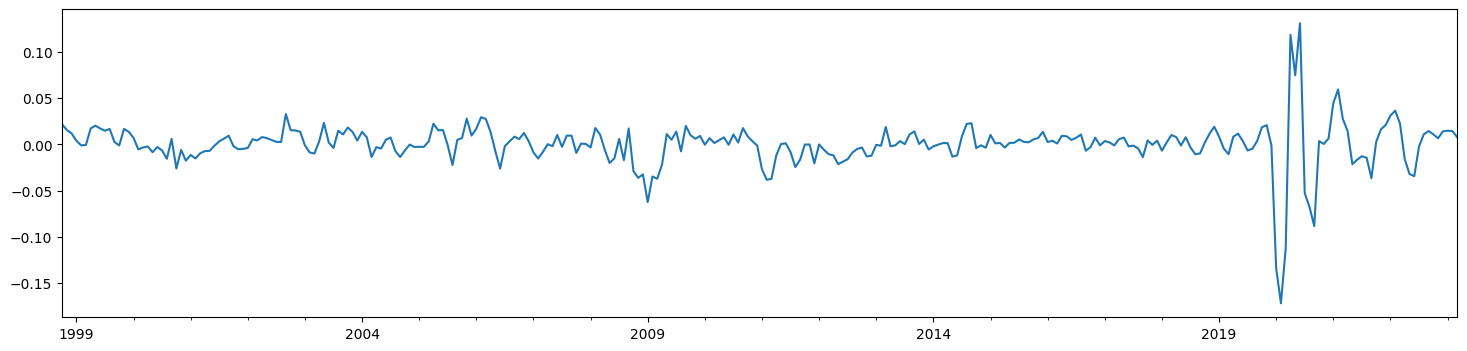

In [9522]:
results.resid.plot()

<Axes: >

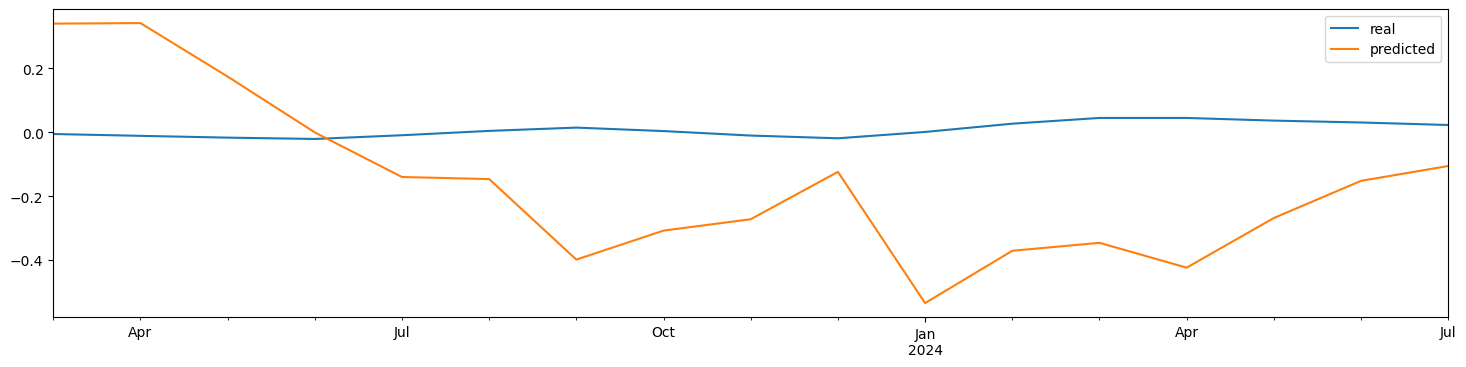

In [9523]:
ypred = results.predict(X)
Xnew = reg1.loc[end_test_date:, chooseThese[1]:]
Xnew[['const']] = 1
reg1.loc[end_test_date:, ['gdp_total']]

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.loc[end_test_date:, 'gdp_total'], 'predicted': ynewpred})
df_pred.plot()


Heteroskedasticity (Breusch-Pagan)


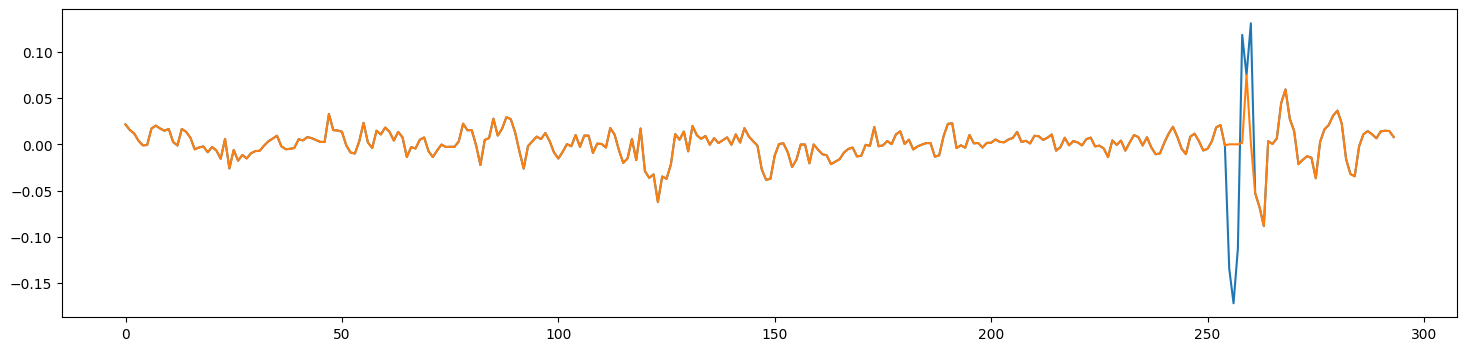

In [9524]:

plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Remove Covid for tests
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Homoskedasticity
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

In [9525]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Colinearity

In [9526]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

0.8623476435341542
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


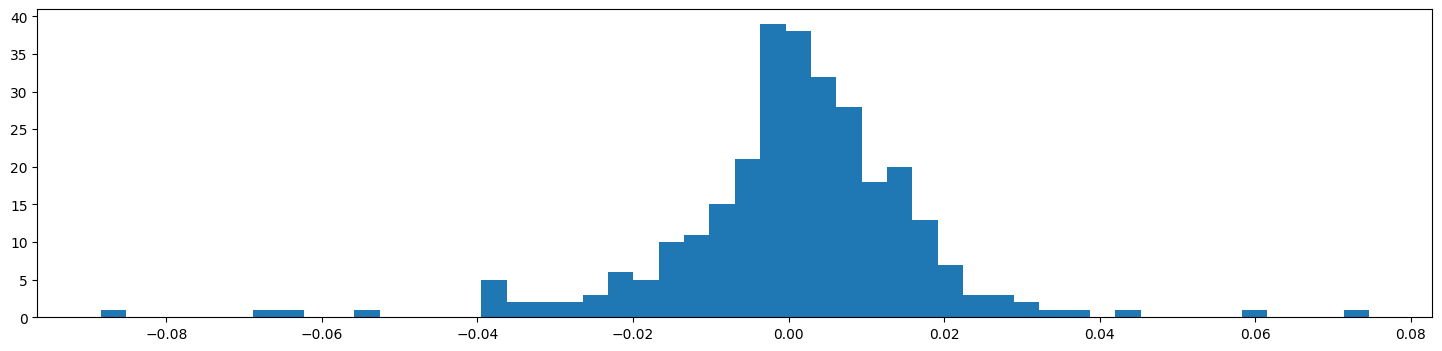

In [9527]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

In [9528]:

def test_reverse_transform(start_date_analysis, my_data_to_untransform):

    GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
    GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

    def diff_inv_Transformation(df_diff, first_value):
        series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
        return series_inverted

    def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
        return data * std + mean


    data_to_untransform = my_data_to_untransform
    date_start_difference = pd.to_datetime(start_date_analysis) + relativedelta(months=1)

    test1 = std_inv_Transformation(diff_inv_Transformation(data_to_untransform, GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']))

    return test1

tes1 = test_reverse_transform(start_date_analysis, y_true)



<Axes: >

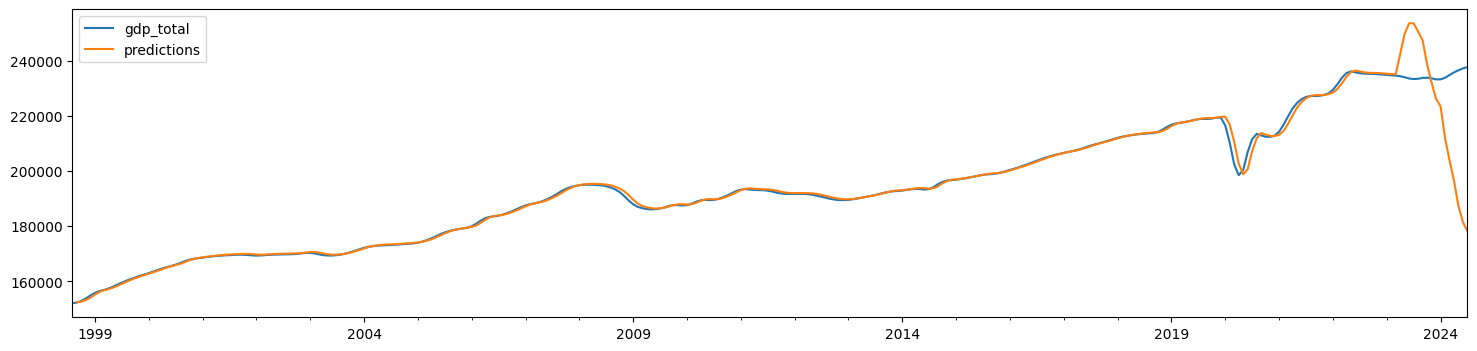

In [9529]:
# create new column with existing data from gdp_total_scaled_diff, then replace with predictions values
GDP_TRANSFORMATIONS["predicts_before_transformations"] = GDP_TRANSFORMATIONS['gdp_total_scaled_diff']
GDP_TRANSFORMATIONS.loc[end_test_date:, 'predicts_before_transformations'] = ynewpred

predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:-1])
GDP_TRANSFORMATIONS['predictions'] = np.append(np.nan, predictions)

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()